# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 1. Откройте и изучите файл

In [2]:
df = pd.read_csv('./users_behavior.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Вывод
Данные прочитаны. Изучены. Обработка не требуется

## 2. Разбейте данные на выборки


In [3]:
# Функция перемешивает датасет df и возвращает три части: train_size и две validate_size

def train_validate_test_split(df, train_size=.6, validate_size=.2, random_state = 42):
    np.random.seed(random_state)
    mix = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_size * m)
    validate_end = int(validate_size * m) + train_end
    train = df.iloc[mix[:train_end]]
    validate = df.iloc[mix[train_end:validate_end]]
    test = df.iloc[mix[validate_end:]]
    return train, validate, test

Создаем выборки

In [4]:
df_train, df_valid, df_test = train_validate_test_split(df, random_state = 42)

In [5]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test[['is_ultra']]

## 3. Исследуйте модели

In [6]:
# Глобальные переменные
best_model_score = 0.0
best_train_model: object()
    
# Гиперпараметры 
greater_depth = 15  #  max_depth
n_estimator = 60  # n_estimators
step_estimators = 5 # шаг n_estimators

In [7]:
def model_fit(model):
    global best_train_model
    global best_model_score
    t = timer()
    model.fit(features_train, target_train)
    elapsed = timer() - t
    model_score = model.score(features_valid, target_valid)
    if model_score > best_model_score:
        best_model_score = model_score
        best_train_model = model
    return model_score, elapsed

# Строит графики с результатами обучения при различных гиперпараметрах
def plot_fit_model(df, title):
    x = df.iloc[:,[0]]
    y1 = df['accuracy']
    y2 = df['elapsed']

    fig, ax1 = plt.subplots(1,1,figsize=(12,5), dpi= 80)
    ax1.plot(x, y1, color='tab:red')

    ax2 = ax1.twinx()  # создание экземпляра второй оси, которая имеет ту же самую ось x
    ax2.plot(x, y2, color='tab:blue')

    ax1.set_xlabel(df.iloc[:,[0]].columns.values, fontsize=14)
    ax1.tick_params(axis='x', rotation=0, labelsize=12)
    ax1.set_ylabel('accuracy', color='tab:red', fontsize=14)
    ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
    ax1.grid(alpha=.4)

    
    ax2.set_ylabel('Время обучения (сек.)', color='tab:blue', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_title(title, fontsize=20)
    fig.tight_layout()
    plt.show()

# Запускает обучение деревьев в циле с различными гиперпараметрами
def tree_calculate():
    tree_stat = []
    for depth in range(1, greater_depth):
        tree_model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
        tree_model_score, elapsed = model_fit(tree_model)
        tree_stat.append([depth, round(tree_model_score, 2), round(elapsed,4)])
        #print("max_depth =", depth, ", ", end='')
        #print('accuracy: {0:.2}, Время обучения: {1:.4}'.format(tree_model_score, elapsed))
    df = pd.DataFrame(tree_stat, columns = ['max_depth', 'accuracy', 'elapsed'])
    plot_fit_model(df, 'Обучение DecisionTreeClassifier')

# Запускает обучение леса в циле с различными гиперпараметрами
def Forest_calculate():
    tree_stat = []
    for estimators in range(1, n_estimator, step_estimators):
        forest_model = RandomForestClassifier(random_state=12345, n_estimators = estimators)
        forest_model_score, elapsed = model_fit(forest_model)
        tree_stat.append([estimators, round(forest_model_score, 2), round(elapsed,4)])
    df = pd.DataFrame(tree_stat, columns = ['n_estimators', 'accuracy', 'elapsed'])
    plot_fit_model(df, 'Обучение RandomForestClassifier')

Решающее дерево 

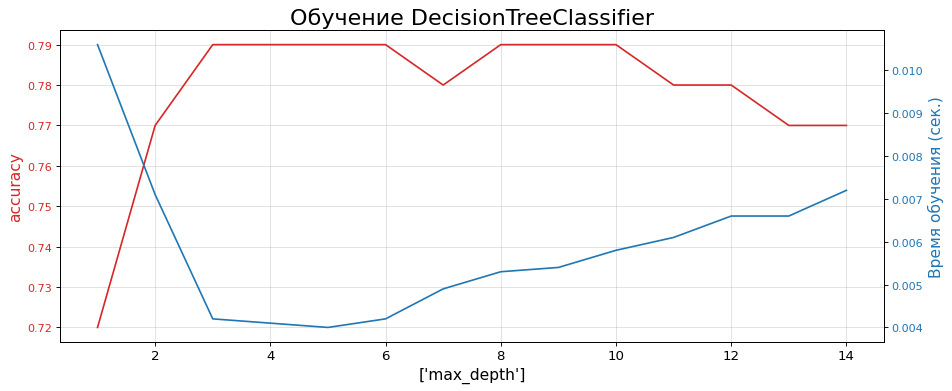

In [8]:
tree_calculate()

Случайный лес

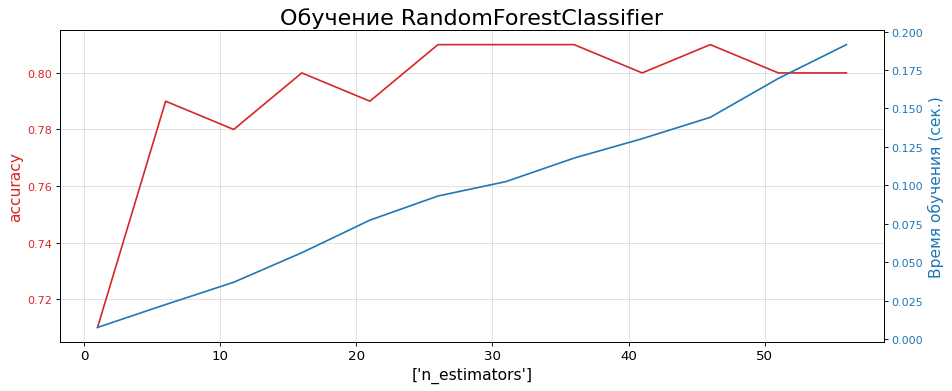

In [9]:
Forest_calculate()

Логистическая регрессия

In [10]:
LR_model = LogisticRegression(random_state=12345)
LR_model_score, elapsed = model_fit(LR_model)

print('accuracy: {0:.2}, Время обучения: {1:.4}'.format(LR_model_score, elapsed))

accuracy: 0.7, Время обучения: 0.03124


### Вывод



In [11]:
print('Лучшая модель по результатам валидации:\n' , best_train_model)
print('Точность модели (accuracy) : {:.2}'. format(best_model_score))

Лучшая модель по результатам валидации:
 RandomForestClassifier(n_estimators=26, random_state=12345)
Точность модели (accuracy) : 0.81


## 4. Проверка модели на тестовой выборке

In [12]:
predictions_test = best_train_model.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
print('Точность модели (accuracy) на тестовых данных : {:.2}'. format(accuracy_test))

Точность модели (accuracy) на тестовых данных : 0.8


## 5. (бонус) Проверка модели на адекватность

Проверка модели в сравнении со случайными средними данными. Среднее целевого тестового датасета показывает отношение с которым тариф является "ультра". Заполним датасет случайными 0 и 1 с той же вероятностью появления тарифа ультра, что и в тестовой выборке.

In [13]:
target_test.mean()

is_ultra    0.309006
dtype: float64

In [14]:
share = round(target_test.mean().values[0] * 100)
predictions_random_mean = pd.Series(
    random.choices(
        [1, 0], 
        weights=[share, 100-share], 
        k=len(target_test)), 
    index=target_test.index)
#print(predictions_random_mean.mean())
accuracy_random_mean = accuracy_score(target_test, predictions_random_mean)
print('accuracy случайной средней модели: {:.2}'. format(accuracy_random_mean))

accuracy случайной средней модели: 0.57


Проверка модели в сравнении с медианой. В классификации из двух категорий создаем датасет с тарифом "смарт" для всех пользователей.

In [15]:
target_test.median()

is_ultra    0.0
dtype: float64

In [16]:
predictions_random_median = pd.Series(0.0, index=target_test.index)
accuracy_random_median = accuracy_score(target_test, predictions_random_median)
print('accuracy медианы: {:.2}'. format(accuracy_random_median))

accuracy медианы: 0.69


In [17]:
print('улучшение обученной модели от случайной средней {0:.2}'.format(accuracy_test - accuracy_random_mean))
print('улучшение обученной модели от медианы {0:.2} '.format(accuracy_test - accuracy_random_median))

улучшение обученной модели от случайной средней 0.23
улучшение обученной модели от медианы 0.11 


## Вывод 
Обучена модель для задачи классификации, которая выберет подходящий тариф. В сравнении по метрике accuracy (Отношение числа правильных ответов к размеру тестовой выборки), модель превосходит результаты простых решений. Модель вменяемая.